In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, RFE
import pickle

from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('bankloans.csv')
data

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN


In [3]:
data.shape

(850, 9)

In [4]:
data.isna().sum()

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [5]:
data = data.dropna()
data

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36,2,6,15,27,4.6,0.262062,0.979938,1.0
696,29,2,6,4,21,11.5,0.369495,2.045505,0.0
697,33,1,15,3,32,7.6,0.491264,1.940736,0.0
698,45,1,19,22,77,8.4,2.302608,4.165392,0.0


In [6]:
data['default'] = data.default.astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    int64  
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int32  
dtypes: float64(3), int32(1), int64(5)
memory usage: 52.0 KB


C:\Users\dell\AppData\Local\Temp\ipykernel_10720\2700588151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['default'] = data.default.astype('int')


In [7]:
[data[i].skew() for i in data.columns]

[0.36147820320045854,
 1.2013195293158183,
 0.831153576061581,
 0.9380976195252814,
 3.8587482818856196,
 1.0960633474617312,
 3.8986170026057385,
 2.7281630721738597,
 1.0881977801921405]

In [8]:
data.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

<AxesSubplot:>

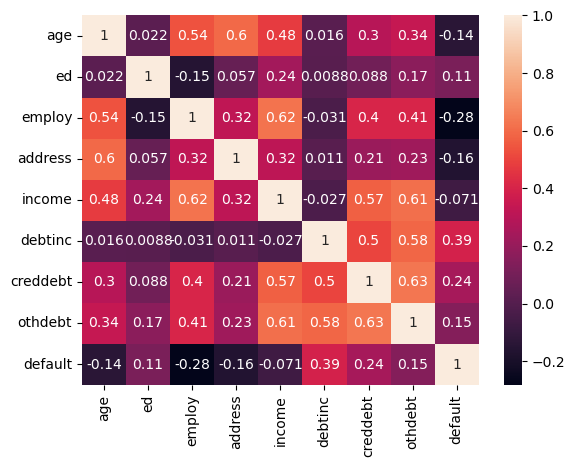

In [9]:
sns.heatmap(data.corr(), annot=True)

In [10]:
def treat_outlier(x):
    x = x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99))
    return

In [11]:
data.apply(treat_outlier)

age         None
ed          None
employ      None
address     None
income      None
debtinc     None
creddebt    None
othdebt     None
default     None
dtype: object

In [12]:
data.default.value_counts(normalize=1)

0    0.738571
1    0.261429
Name: default, dtype: float64

In [13]:
data.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [14]:
data.rename(columns={'ed': 'education', 'debtinc':'debt_to_income', 'creddebt':'cred_debt', 'otherdebt':'other_debt'}, inplace=True)
data.columns

C:\Users\dell\AppData\Local\Temp\ipykernel_10720\1381822110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'ed': 'education', 'debtinc':'debt_to_income', 'creddebt':'cred_debt', 'otherdebt':'other_debt'}, inplace=True)


Index(['age', 'education', 'employ', 'address', 'income', 'debt_to_income',
       'cred_debt', 'othdebt', 'default'],
      dtype='object')

In [15]:
#### Splitting X,y 

X = data.drop(columns='default')
y = data.default

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=121)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(490, 8)
(210, 8)
(490,)
(210,)


In [18]:
y_train.value_counts()

0    357
1    133
Name: default, dtype: int64

In [19]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [20]:
print(X_train.shape)
print(y_train.shape)

(714, 8)
(714,)


In [21]:
model_0 = RandomForestClassifier(max_depth=5)
model_0.fit(X_train,y_train)

RandomForestClassifier(max_depth=5)

In [22]:
print(classification_report(y_train, model_0.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       357
           1       0.87      0.91      0.89       357

    accuracy                           0.89       714
   macro avg       0.89      0.89      0.89       714
weighted avg       0.89      0.89      0.89       714



In [23]:
print(classification_report(y_test, model_0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       160
           1       0.46      0.60      0.52        50

    accuracy                           0.74       210
   macro avg       0.66      0.69      0.67       210
weighted avg       0.77      0.74      0.75       210



In [24]:
sel_feature = SelectKBest(k=5)
sel_feature.fit(X_train,y_train)

SelectKBest(k=5)

In [25]:
sel_feature.get_feature_names_out()

array(['employ', 'address', 'debt_to_income', 'cred_debt', 'othdebt'],
      dtype=object)

In [26]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
rfe.fit(X_train,y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

In [27]:
rfe.get_feature_names_out()

array(['employ', 'income', 'debt_to_income', 'cred_debt', 'othdebt'],
      dtype=object)

In [28]:
X_train = X_train[rfe.get_feature_names_out()]
X_test = X_test[rfe.get_feature_names_out()]

In [29]:
print(X_train.shape)
print(X_test.shape)

(714, 5)
(210, 5)


In [30]:
data.head()

,age,education,employ,address,income,debt_to_income,cred_debt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


In [31]:
param_grid = { 'n_estimators': [20,50,100],
              'criterion' : ['gini','entropy'],
              'max_depth' : [3,5,8,10]
    
}

In [32]:
grid_cv = GridSearchCV(estimator= RandomForestClassifier(oob_score=True), param_grid=param_grid, cv = 5,  verbose=True )
grid_cv.fit(X_train  , y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [20, 50, 100]},
             verbose=True)

In [33]:
grid_cv.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 50}

In [34]:
grid_cv.best_score_

0.8151186841327686

In [35]:
RandomForestClassifier()

RandomForestClassifier()

In [36]:
model_final = RandomForestClassifier(n_estimators=100, criterion='gini',  max_depth=10)
model_final.fit(X_train,y_train)

RandomForestClassifier(max_depth=10)

In [37]:
print(classification_report(y_train,model_final.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       357

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714



In [38]:
print(classification_report(y_test,model_final.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.76      0.81       160
           1       0.43      0.58      0.50        50

    accuracy                           0.72       210
   macro avg       0.64      0.67      0.65       210
weighted avg       0.75      0.72      0.73       210



In [39]:
filename = "banking.pkl"
pickle.dump(model_final, open(filename, 'wb'))

In [40]:
retrieved_model = pickle.load(open(filename,'rb'))

In [41]:
retrieved_model.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
X_train.columns

Index(['employ', 'income', 'debt_to_income', 'cred_debt', 'othdebt'], dtype='object')